## Spatial covariance of wind sites

---
[Tastu2015][1]: Use a Gaussian Copula function to link individual densities together into a joint density. The joint density contains spatial and temporal covariance information.

* Pg2: "An overview of the history of wind power forecasting, though mainly focused on deterministic approaches, as well as an extensive review of the state of the art in that field, are given in [10] and [14], respectively. In parallel, an overview of the current forecasting challenges can be found in [33]."
    * [10] [A. Costa, A. Crespo, J. Navarro, G. Lizcano, H. Madsen, and E. Feitosa. A review on the young history of the wind power short-term prediction. Renew. Sust. Energ. Rev., 12(6):1725–1744, 2008.][3]
    * [14] [G. Giebel, R. Brownsword, G. Kariniotakis, M. Denhard, and C. Draxl. The state-of-the-art in short-term prediction of wind power–A literature overview. 2nd edition. Technical report, Technical University of Denmark, 2011.][4]
    * [33] [P. Pinson. Wind energy: Forecasting challenges for its optimal management. Stat. Sci., 28(4):564–585, 2013.][5]
    
* Pg6: "the marginal predictive densities can be linked together ... using a copula function. Mathematically the foundation of copulas is given by [Sklar's theorem][6] [42], which states that, for any multivariate cumulative distribution function $F_t$ with marginals $F_{t,1},\ldots,F_{t,n}$ there exists a copula function $C$ such that 
$$ F_t(y_1,\ldots,y_n) = C(F_{t,1}(y_1),\ldots,F_{t,n}(y_n)). $$
"In the case where the joint distribution to be modelled involves continuous random variables only, as for wind power generation, the copula $C$ is unique."

* Pg7: "The Gaussian copula could be seen [sic] suitable for describing the spatio-temporal dependence structure. ... Here it is our choice to focus on Gaussian copulas only, owing to the resulting opportunities given in terms of dependence structure modelling with precision matrices only."

* Pg8: "A Gaussian copula is given by 
$$ C(F_{t,1}(y_1),\ldots,F_{t,n}(y_n)) = \Phi_\Sigma\left( \Phi^{-1}(F_{t,1}(y_1).\ldots,\Phi^{-1}(F_{t,n}(y_n))\right), $$
where $\Phi^{-1}$ denotes the inverse of the standard Gaussian cumulative distribution function and $\Phi_\Sigma(\cdot)$ is the $n$-variate Gaussian distribution function with zero mean, unit marginal variances and a correlation matrix $\Sigma$."

* Pg9:  In order to make the proposed methodology applicable for problems of high dimension, instead of modelling the covariance matrix directly, we focus on its inverse, the precision matrix, denoted by Q [41].

* Pg14: Spatial neighborhood. Precision matrix has nonzero elements for only the North, South, East, and West neighbors.

* Pg15: Temporal neighborhood. Nonzero precision matrix elements for time steps $\{-2,-1,0,1,2\}$. Can assume second-order effects are negligible, so use $\{-1,0,1\}$ only.

* Pg16: To ensure symmetry, if $i$ is the west-side, one-hour-ago neighbor of $k$, then $k$ must be the east-side, one-hour-ahead neighbor of $i$.

* Pg16: Summary of non-zero precision matrix elements. "Our analysis over the first data subset suggested that information for zone A at lead time $k$ conditionally depends on information from zones N, E, S, and W with lead times $k-1,k,k+1$, as well as on the local situation at zone $A$ for lead ties $k-1$ and $k+1$."

**First-pass strategy based on this paper**

1. Use geographic positions to tile wind farms. Each of a farm's neighbors must be classified as N, S, W, or E.

2. Construct a symmetric precision matrix with the following nonzero elements for each farm (use a different constant for each line below):
    * four neighbors at previous time step
    * four neighbors at current time step
    * four neighbors at next time step
    * current farm at previous time step
    * current farm at next time step 
3. Ensure precision matrix is positive definite

---
[Wytock2013][2]: 

* 

[1]: http://dx.doi.org/10.1007/978-3-319-18732-7_14
[2]: http://dx.doi.org.proxy.lib.umich.edu/10.1109/CDC.2013.6760016
[3]: http://dx.doi.org/10.1016/j.rser.2007.01.015
[4]: http://orbit.dtu.dk/en/publications/the-stateoftheart-in-shortterm-prediction-of-wind-power(0d76e147-4bfc-444b-af00-13a0db8f132e).html
[5]: http://projecteuclid.org/euclid.ss/1386078879
[6]: https://en.wikipedia.org/wiki/Copula_(probability_theory)#Sklar.27s_theorem

## New Qobj function

In [33]:
# optional corr argument sets correlation matrix
function tmp_inst_Qobj(n,nr,T,corr=[]; pad=true)
    if isempty(corr)
        Qobj = spdiagm(repeat([ones(nr);zeros(n+1)],outer=[T]))
    else
        corr = sparse(corr)
        Qobj = blkdiag(corr,spzeros(n+1,n+1))
        for t = 2:T
            Qobj = blkdiag(Qobj,blkdiag(corr,spzeros(n+1,n+1)))
        end
    end

    if !pad
        return Qobj
    else
        # Add T rows and columns of zeros to Q:
        r,c = size(Qobj)
        return [[Qobj spzeros(r,T)]; spzeros(T,c+T)]
    end
end

tmp_inst_Qobj (generic function with 2 methods)

## Testing: toy example

In [42]:
using RandomCorrelationMatrices

In [12]:
n = 3
nr = 2
T = 2
corr = abs(randcovmatrix(nr,η,ones(nr)))
QobjC = tmp_inst_Qobj(n,nr,T,corr)
Qobj = tmp_inst_Qobj(n,nr,T)

14x14 sparse matrix with 4 Float64 entries:
	[1 ,  1]  =  1.0
	[2 ,  2]  =  1.0
	[7 ,  7]  =  1.0
	[8 ,  8]  =  1.0

In [13]:
(norm(full(Qobj)),norm(full(QobjC)))

(1.0,1.1733616854900386)

In [14]:
norm(full(QobjC)/norm(full(QobjC)))

0.9999999999999999

$Q_{obj}$ is the *inverse* of the covariance matrix.

## Testing: RTS-96

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

In [2]:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

438-element Array{Float64,1}:
 0.0      
 0.0820657
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      

In [3]:
using RandomCorrelationMatrices
η = 2
nr = length(inputData.Ridx)
corr = randcovmatrix(nr,η,ones(nr))
D,V = eig(corr)
if(minimum(d) <= 0.0)
    warn("Negative eig")
end
scale!(corr,1/norm(corr))

 in depwarn at ./deprecated.jl:63
 in chol at deprecated.jl:496
 in randcormatrix at /home/jkersulis/.julia/v0.4/RandomCorrelationMatrices/src/RandomCorrelationMatrices.jl:29
 in randcovmatrix at /home/jkersulis/.julia/v0.4/RandomCorrelationMatrices/src/RandomCorrelationMatrices.jl:43
 in include_string at loading.jl:225
 in execute_request_0x535c5df2 at /home/jkersulis/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /home/jkersulis/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 4


18x18 Array{Float64,2}:
  0.332891     -0.101987   -0.0825132   …   0.0693285    0.161623  
 -0.101987      0.332891    0.0508368       0.068279    -0.0589694 
 -0.0825132     0.0508368   0.332891       -0.0186325   -0.176973  
  0.0658589    -0.0864123  -0.060392       -0.0596902    0.0483635 
  0.00297898   -0.0812778   0.0116657      -0.0494978    0.0324464 
  0.000345315  -0.0135934  -0.0288444   …   0.115048     0.125597  
 -0.0319136     0.048336    0.050315       -0.0562339    0.0111493 
 -0.0619326    -0.0786648   0.109316       -0.0796869   -0.0769628 
  0.142252     -0.130441   -0.140927       -0.00724099   0.0939707 
  0.0769605     0.0313187   0.0149775       0.148595     0.0612951 
  0.0319863     0.0617673  -0.034871    …  -0.00460859  -0.0301711 
  0.0493333    -0.0613224  -0.00473762      0.0852626   -0.0392542 
 -0.107419     -0.0446696  -0.0618751       0.0186108    0.00465537
 -0.0633016     0.15852    -0.0277879       0.0781697   -0.0345378 
  0.00775433   -0.134889

 in depwarn at ./deprecated.jl:63
 in chol at deprecated.jl:496
 in randcormatrix at /home/jkersulis/.julia/v0.4/RandomCorrelationMatrices/src/RandomCorrelationMatrices.jl:29
 in randcovmatrix at /home/jkersulis/.julia/v0.4/RandomCorrelationMatrices/src/RandomCorrelationMatrices.jl:43
 in include_string at loading.jl:225
 in execute_request_0x535c5df2 at /home/jkersulis/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /home/jkersulis/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 4


In [8]:
inputData.corr = corr

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

	From worker 3:	finished 70/104
	From worker 2:	finished 10/104
	From worker 2:	finished 20/104
	From worker 3:	finished 80/104


	From worker 2:	finished 30/104


	From worker 3:	finished 90/104
	From worker 3:	finished 100/104
	From worker 2:	finished 40/104
	From worker 3:	finished 110/104
	From worker 2:	finished 50/104
	From worker 2:	finished 60/104
  1.832300 seconds (19.71 k allocations: 2.637 MB)


In [10]:
# repeat without covariance matrix
inputData.corr = Array{Float64,2}()

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData_noCov = process_instanton_results(results,n,nr,T,return_as_type=true);

	From worker 3:	finished 70/104
	From worker 2:	finished 10/104
	From worker 2:	finished 20/104
	From worker 3:	finished 80/104


	From worker 2:	finished 30/104


	From worker 3:	finished 90/104
	From worker 3:	finished 100/104
	From worker 2:	finished 40/104
	From worker 3:	finished 110/104
	From worker 2:	finished 50/104
	From worker 2:	finished 60/104
  1.867283 seconds (23.43 k allocations: 2.381 MB)


In [12]:
using PyPlot
PyPlot.svg(true)

true

In [47]:
diff_diffs = Vector{Float64}()
for eidx in 1:104
    push!(diff_diffs,
    maxabs(
        outputData_noCov.diffs[sortperm(outputData_noCov.score)][eidx] - 
        outputData.diffs[sortperm(outputData.score)][eidx])
    )
end

In [51]:
corr

18x18 Array{Float64,2}:
  0.332891     -0.101987   -0.0825132   …   0.0693285    0.161623  
 -0.101987      0.332891    0.0508368       0.068279    -0.0589694 
 -0.0825132     0.0508368   0.332891       -0.0186325   -0.176973  
  0.0658589    -0.0864123  -0.060392       -0.0596902    0.0483635 
  0.00297898   -0.0812778   0.0116657      -0.0494978    0.0324464 
  0.000345315  -0.0135934  -0.0288444   …   0.115048     0.125597  
 -0.0319136     0.048336    0.050315       -0.0562339    0.0111493 
 -0.0619326    -0.0786648   0.109316       -0.0796869   -0.0769628 
  0.142252     -0.130441   -0.140927       -0.00724099   0.0939707 
  0.0769605     0.0313187   0.0149775       0.148595     0.0612951 
  0.0319863     0.0617673  -0.034871    …  -0.00460859  -0.0301711 
  0.0493333    -0.0613224  -0.00473762      0.0852626   -0.0392542 
 -0.107419     -0.0446696  -0.0618751       0.0186108    0.00465537
 -0.0633016     0.15852    -0.0277879       0.0781697   -0.0345378 
  0.00775433   -0.134889

In [46]:
eidx = 1
outputData_noCov.x[sortperm(outputData_noCov.score)][eidx][i]

6-element Array{Any,1}:
 [-0.0006466365892753845,-0.0023175276535732925,0.0007890044787757233,0.0007212890273535777,0.0006897492535955507,0.0004349839435695557,0.0001271400001600087,0.0006604623210080263,-4.217416879859215e-5,-0.00028457210447641046,-0.00023272608905244851,-0.0002267269493358981,-0.000228204313557967,-0.00019185690575795888,-0.00017186583158945723,0.0002683610408240611,0.0002759536741621105,0.00027292353945540526]
 [-0.001752561382714568,-0.006281131532708595,0.002138417163777717,0.001954889835985796,0.0018694084533734667,0.0011789250330664913,0.0003445840496966168,0.0017900328841733426,-0.00011430349110419513,-0.0007712679569351621,-0.0006307511250724929,-0.0006144918216932638,-0.00061849588210805,-0.0005199845010110948,-0.0004658032413544788,0.0007273315568081529,0.0007479096621239023,0.0007396971714683787]        
 [-0.0047608973665537735,-0.017062924508001065,0.005809088766802972,0.005310530039935202,0.005078316725018794,0.003202593152550115,0.0009360752271524997,0

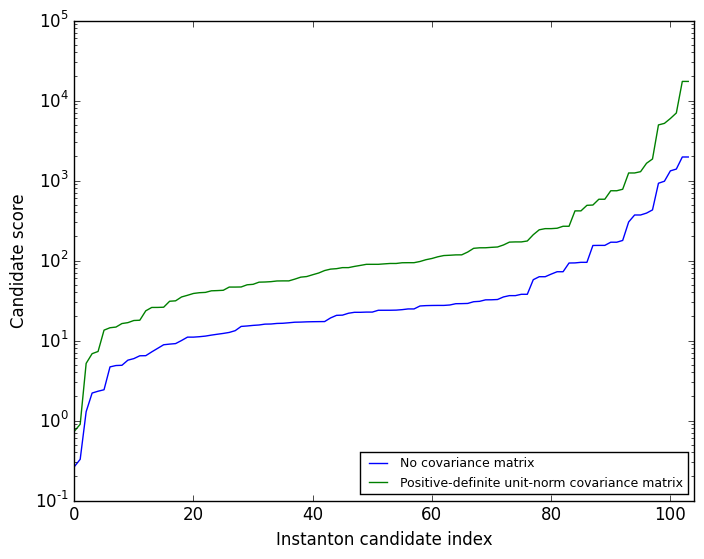

In [13]:
plot(sort(outputData_noCov.score))
hold(true)
plot(sort(outputData.score))
yscale("log")
xlim([0;104])
xlabel("Instanton candidate index")
ylabel("Candidate score")
legend(["No covariance matrix";"Positive-definite unit-norm covariance matrix"],fontsize=9,loc=4)

savefig("../images/2015-09-15-score-by-covariance.svg")